In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
from keras.layers import Dense, LSTM, RNN, GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
import math as mt
from keras.callbacks import History 
from keras import backend as K

In [47]:
usdeuro_df = yf.download('EUR=X',
                         start='2013-01-01',
                         interval='1d')
usdeuro_df.shape


[*********************100%***********************]  1 of 1 completed


(2610, 6)

In [48]:
fig = go.Figure(data=[go.Candlestick(x=usdeuro_df.index,
                                     open=usdeuro_df.Open,
                                     high=usdeuro_df.High,
                                     low=usdeuro_df.Low,
                                     close=usdeuro_df.Close)])
fig.show()

In [49]:
usdeuro_df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-01,0.75750,0.757810,0.756200,0.75750,0.75750,0
2013-01-02,0.75770,0.757900,0.751990,0.75770,0.75770,0
2013-01-03,0.75850,0.764000,0.758200,0.75860,0.75860,0
2013-01-04,0.76740,0.769200,0.765474,0.76730,0.76730,0
2013-01-07,0.76520,0.768014,0.763400,0.76526,0.76526,0
2013-01-08,0.76200,0.765250,0.761140,0.76190,0.76190,0
2013-01-09,0.76430,0.766930,0.763650,0.76439,0.76439,0
2013-01-10,0.76607,0.766810,0.756660,0.76600,0.76600,0
2013-01-11,0.75340,0.754600,0.748385,0.75340,0.75340,0


In [50]:
usdeuro_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2013-01-01 to 2023-01-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2610 non-null   float64
 1   High       2610 non-null   float64
 2   Low        2610 non-null   float64
 3   Close      2610 non-null   float64
 4   Adj Close  2610 non-null   float64
 5   Volume     2610 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 142.7 KB


In [51]:
usdeuro_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [52]:
usdeuro_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2610.000000,2610.000000,2610.000000,2610.000000,2610.000000,2610.0
mean,0.861489,0.864313,0.858720,0.861474,0.861474,0.0
std,0.067342,0.067945,0.066707,0.067342,0.067342,0.0
min,0.717880,0.718773,0.714740,0.717830,0.717830,0.0
25%,0.824048,0.826183,0.821948,0.824043,0.824043,0.0
50%,0.878395,0.880725,0.875500,0.878350,0.878350,0.0
75%,0.904334,0.907433,0.901629,0.904315,0.904315,0.0
max,1.042080,1.048200,1.034120,1.042080,1.042080,0.0


In [53]:
df = usdeuro_df["Close"]
df

Date
2013-01-01    0.75750
2013-01-02    0.75770
2013-01-03    0.75860
2013-01-04    0.76730
2013-01-07    0.76526
               ...   
2023-01-02    0.93373
2023-01-03    0.93653
2023-01-04    0.94815
2023-01-05    0.94283
2023-01-06    0.95260
Name: Close, Length: 2610, dtype: float64

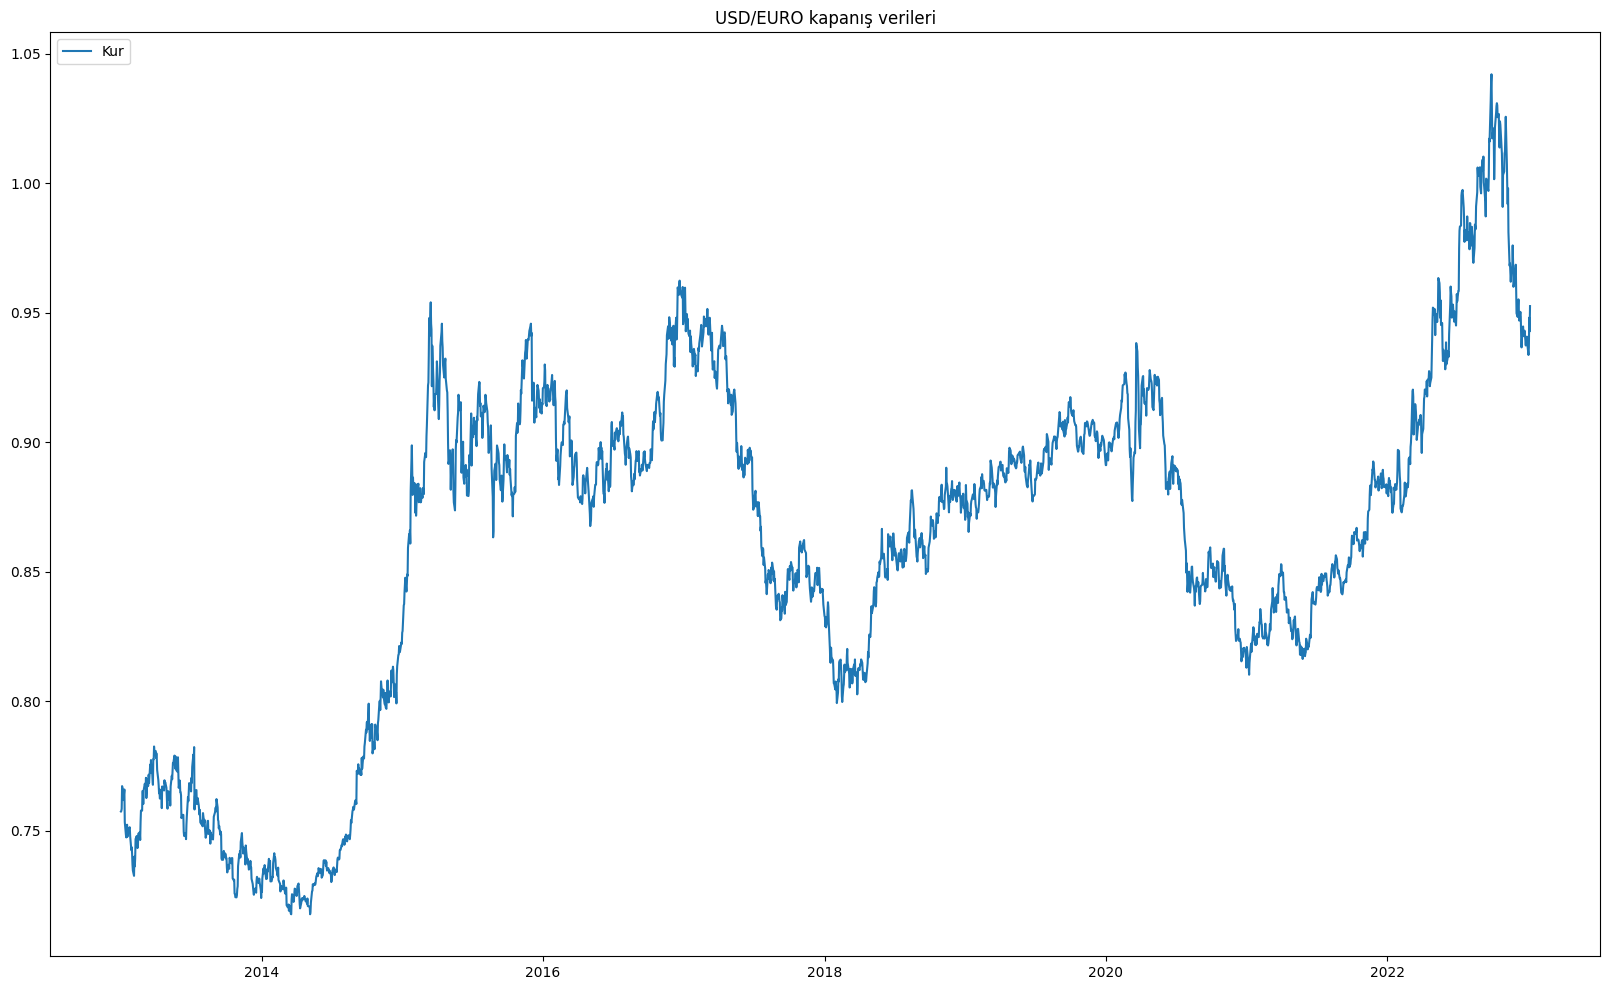

In [54]:
df = usdeuro_df["Close"]
plt.figure(figsize=(20,12))
plt.plot(df, label= "Kur")
plt.title("USD/EURO kapanış verileri")
plt.legend(loc="upper left")
plt.show()

In [55]:
#0.8 train, 0.1 test, 0.1 validation
df_reshaped = df.values.reshape(-1,1)
train_df, valid_df, test_df = df_reshaped[: int(len(df)*0.8)], df_reshaped[int(len(df)*0.8) : int(len(df)*0.9)], df_reshaped[int(len(df)*0.9) :]

In [56]:
#plt.figure(figsize=(20,12))
#plt.plot(train_df, color = "green", label = "Train Dataset")
#plt.plot(test_df, color = "yellow", label = "Test Dataset")
#plt.plot(valid_df, color = "blue", label = "Validation Dataset")
#plt.legend()
#plt.show()

In [57]:
#ax = train_df.plot(figsize=(20,12))
#ax = test_df.plot(ax=ax, figsize=(20,12))
#valid_df.plot(ax=ax)
#plt.legend(['train', 'vaildation', 'test'])

In [58]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)
train_scaled = scaler.transform(train_df)
valid_scaled = scaler.transform(valid_df)
test_scaled = scaler.transform(test_df)

In [59]:
print("Train data size: ", train_scaled.shape[0])
print("Validation data size: ", valid_scaled.shape[0])
print("Test data size: ", test_scaled.shape[0])

Train data size:  2088
Validation data size:  261
Test data size:  261


In [60]:
n_lookback = 20 # windows size - x geçmiş veriye bak
n_future = 1    # y ileri bak

In [61]:
def uc_boyut_array(df, n_lookback, n_future):
    X = []
    y = []
    for i in range(n_lookback, len(df) - n_lookback + 1):
        X.append(df[i - n_lookback: i])
        y.append(df[i: i + n_future])
    return np.array(X), np.array(y)    

In [62]:
X_train, y_train = uc_boyut_array(train_scaled, n_lookback, n_future)
X_valid, y_valid = uc_boyut_array(valid_scaled, n_lookback, n_future)
X_test, y_test = uc_boyut_array(test_scaled, n_lookback, n_future)

In [63]:
#y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
#y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
#y_valid = y_valid.reshape(y_valid.shape[0], y_valid.shape[1])

In [64]:
print("Train of X data size: ", X_train.shape, "      Train of y data size: ", y_train.shape)
print("Test of X data size: ", X_test.shape, "        Test of y data size: ", y_test.shape)
print("Validation of X data size: ", X_valid.shape, "  Validation of y data size: ", y_valid.shape)

Train of X data size:  (2049, 20, 1)       Train of y data size:  (2049, 1, 1)
Test of X data size:  (222, 20, 1)         Test of y data size:  (222, 1, 1)
Validation of X data size:  (222, 20, 1)   Validation of y data size:  (222, 1, 1)


In [65]:
history = History()

In [19]:
#RNN MODELİ
K.clear_session()
model_basicrnn = Sequential()
model_basicrnn.add(Dense(12, input_dim=1,  input_shape=(n_lookback, ) , activation='relu'))
model_basicrnn.add(Dense(units=1))
model_basicrnn.compile(loss="mean_squared_error", optimizer="adam")
model_basicrnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, batch_size=16, verbose=1, callbacks= [history])

Epoch 1/30
129/129 [==============================] - 4s 16ms/step - loss: 0.0514 - val_loss: 0.0011
Epoch 2/30
129/129 [==============================] - 2s 16ms/step - loss: 0.0020 - val_loss: 9.4395e-04
Epoch 3/30
129/129 [==============================] - 2s 15ms/step - loss: 0.0018 - val_loss: 8.8123e-04
Epoch 4/30
129/129 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 8.2487e-04
Epoch 5/30
129/129 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 7.7188e-04
Epoch 6/30
129/129 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 7.1504e-04
Epoch 7/30
129/129 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 5.2919e-04
Epoch 8/30
129/129 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 4.8574e-04
Epoch 9/30
129/129 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 4.7494e-04
Epoch 10/30
129/129 [==============================] - 1s 6ms/st

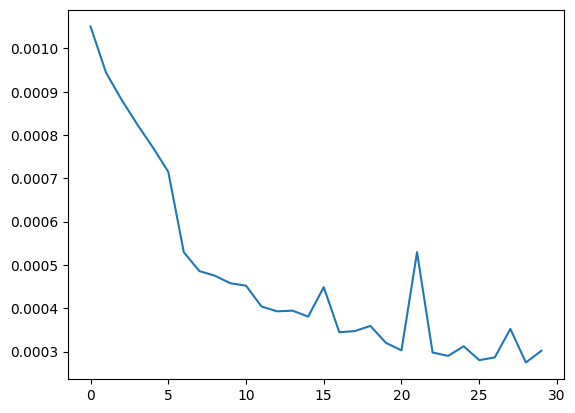

In [26]:
plt.plot(history.history["val_loss"])
plt.show()

In [43]:
# LSTM MODELİ
K.clear_session()
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback,1)))
model.add(LSTM(units=50))
model.add(Dense(n_future))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, batch_size=16, verbose=1, callbacks= [history])

Epoch 1/30
129/129 [==============================] - 9s 33ms/step - loss: 0.0131 - val_loss: 9.0650e-04
Epoch 2/30
129/129 [==============================] - 2s 18ms/step - loss: 0.0018 - val_loss: 7.1729e-04
Epoch 3/30
129/129 [==============================] - 3s 21ms/step - loss: 0.0017 - val_loss: 7.4377e-04
Epoch 4/30
129/129 [==============================] - 2s 17ms/step - loss: 0.0015 - val_loss: 7.7070e-04
Epoch 5/30
129/129 [==============================] - 2s 17ms/step - loss: 0.0013 - val_loss: 5.3813e-04
Epoch 6/30
129/129 [==============================] - 2s 18ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/30
129/129 [==============================] - 3s 25ms/step - loss: 0.0011 - val_loss: 7.1432e-04
Epoch 8/30
129/129 [==============================] - 2s 19ms/step - loss: 0.0012 - val_loss: 3.9569e-04
Epoch 9/30
129/129 [==============================] - 3s 20ms/step - loss: 9.3420e-04 - val_loss: 6.5592e-04
Epoch 10/30
129/129 [==============================] - 

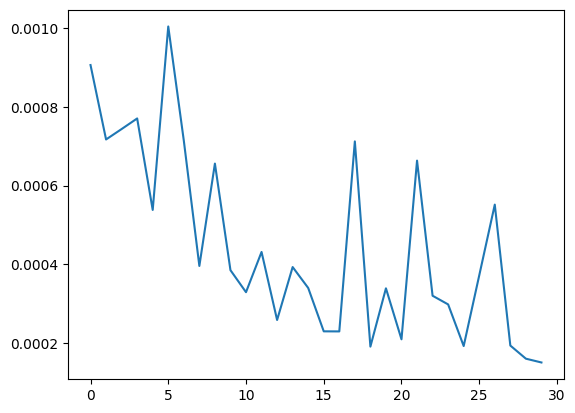

In [44]:
plt.plot(history.history["val_loss"])
plt.show()

In [399]:
def predict_ve_score(model, X, y):
    # Şimdi tahminleri 0-1 ile scale edilmiş halinden geri çeviriyoruz.
    pred = model.predict(X)
    pred = scaler.inverse_transform(pred)
    y = y.reshape(y.shape[0], y.shape[1])
    actual = scaler.inverse_transform(y)
    # Rmse değerlerini ölçüyoruz.
    score = mt.sqrt(mean_squared_error(actual, pred))
    return score, pred

In [400]:
rmse_train, train_predict_rnn = predict_ve_score(model_basicrnn, X_train, y_train)
rmse_test, test_predict_rnn = predict_ve_score(model_basicrnn, X_test, y_test)
rmse_valid, valid_predict_rnn = predict_ve_score(model_basicrnn, X_valid, y_valid)
print("Training data score:  RMSE", rmse_train)
print("Test data score: RMSE", rmse_test)
print("Validation data score: RMSE", rmse_valid)

7/7 [==============================] - 0s 1ms/step
Training data score:  RMSE 0.006657971682427432
Test data score: RMSE 0.009948116179209033
Validation data score: RMSE 0.004547543971760144


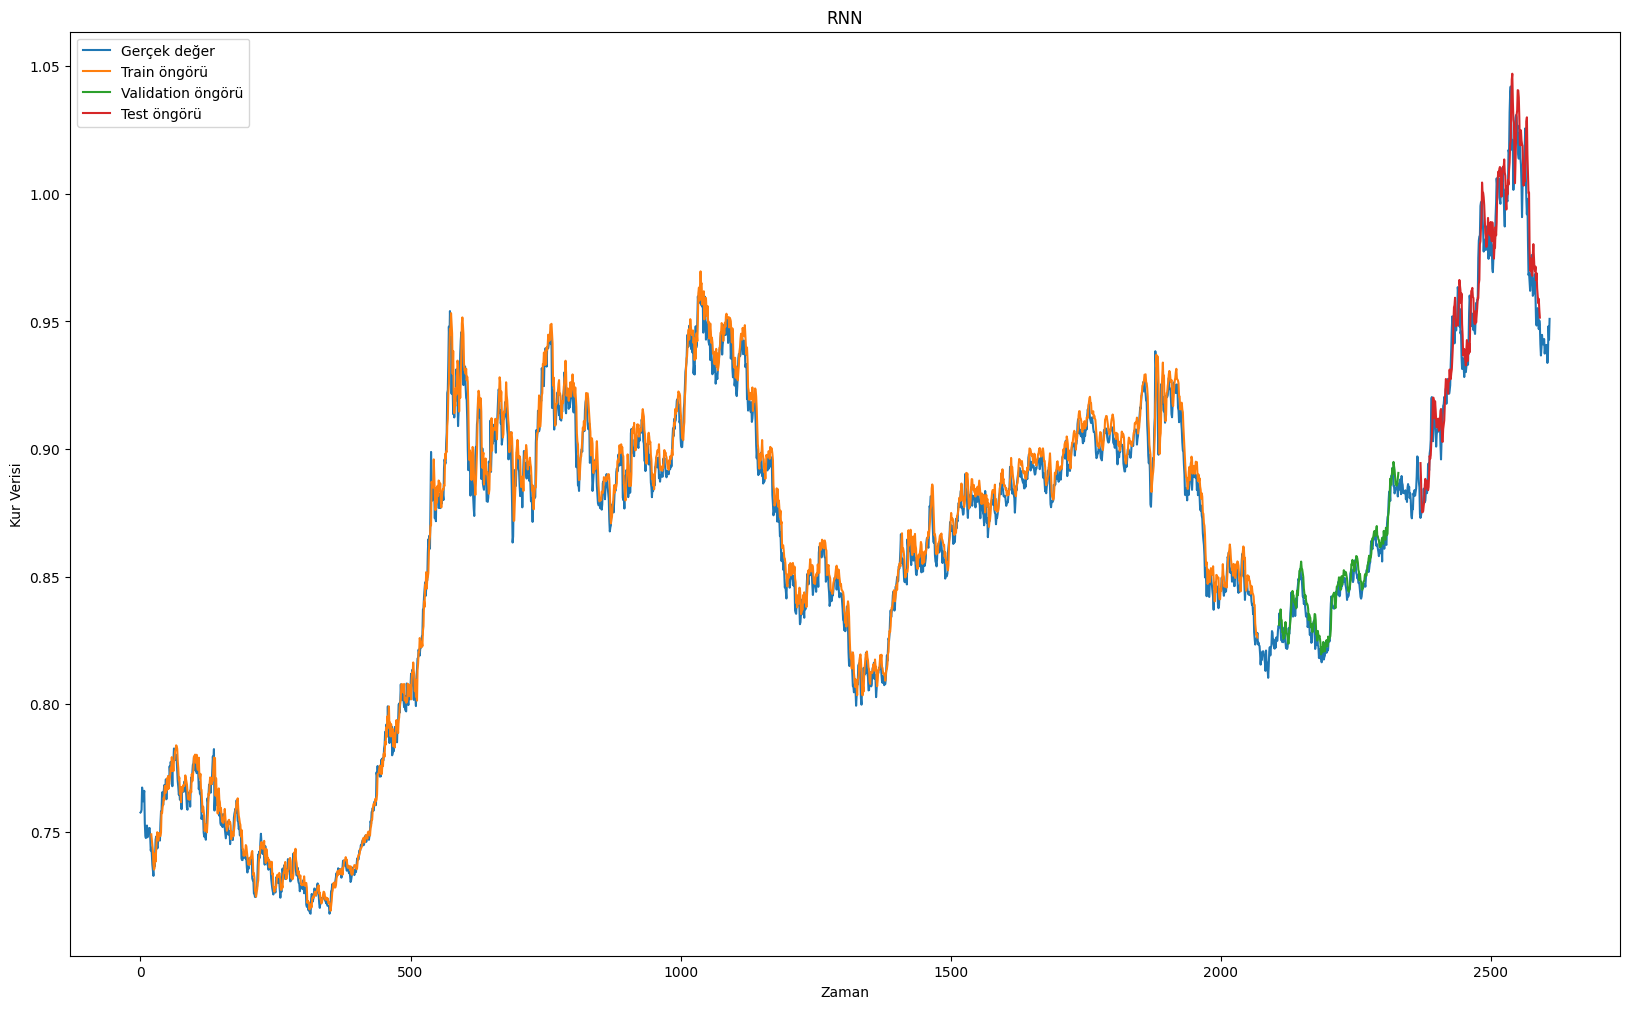

In [403]:
train_predict_plot = np.empty_like(df_reshaped)
train_predict_plot[:, :] = np.nan
train_predict_plot[n_lookback:len(train_predict_rnn) + n_lookback, :] = train_predict_rnn

valid_predict_plot = np.empty_like(df_reshaped)
valid_predict_plot[:, :] = np.nan
valid_predict_plot[len(train_predict_rnn) + (n_lookback * 2) + 19:len(df_reshaped) -len(test_predict_rnn)-n_lookback*2 - 18, :] = valid_predict_rnn

test_predict_plot = np.empty_like(df_reshaped)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_rnn) + len(valid_predict_rnn) + (n_lookback * 2) + 59:len(df_reshaped) - 18, :] = test_predict_rnn

plt.figure(figsize = (20, 12))
plt.plot(df_reshaped, label = "Gerçek değer")
plt.plot(train_predict_plot, label = "Train öngörü")
plt.plot(valid_predict_plot, label = "Validation öngörü")
plt.plot(test_predict_plot, label = "Test öngörü")
plt.xlabel("Zaman")
plt.ylabel("Kur Verisi")
plt.legend()
plt.title("RNN")
plt.show()

In [291]:
rmse_train, train_predict = predict_ve_score(model, X_train, y_train)
rmse_test, test_predict = predict_ve_score(model, X_test, y_test)
rmse_valid, valid_predict = predict_ve_score(model, X_valid, y_valid)
print("Training data score:  RMSE", rmse_train)
print("Test data score: RMSE", rmse_test)
print("Validation data score: RMSE", rmse_valid)



7/7 [==============================] - 0s 4ms/step
Training data score:  RMSE 0.00468361351619639
Test data score: RMSE 0.04162976823755679
Validation data score: RMSE 0.0032634343365750447


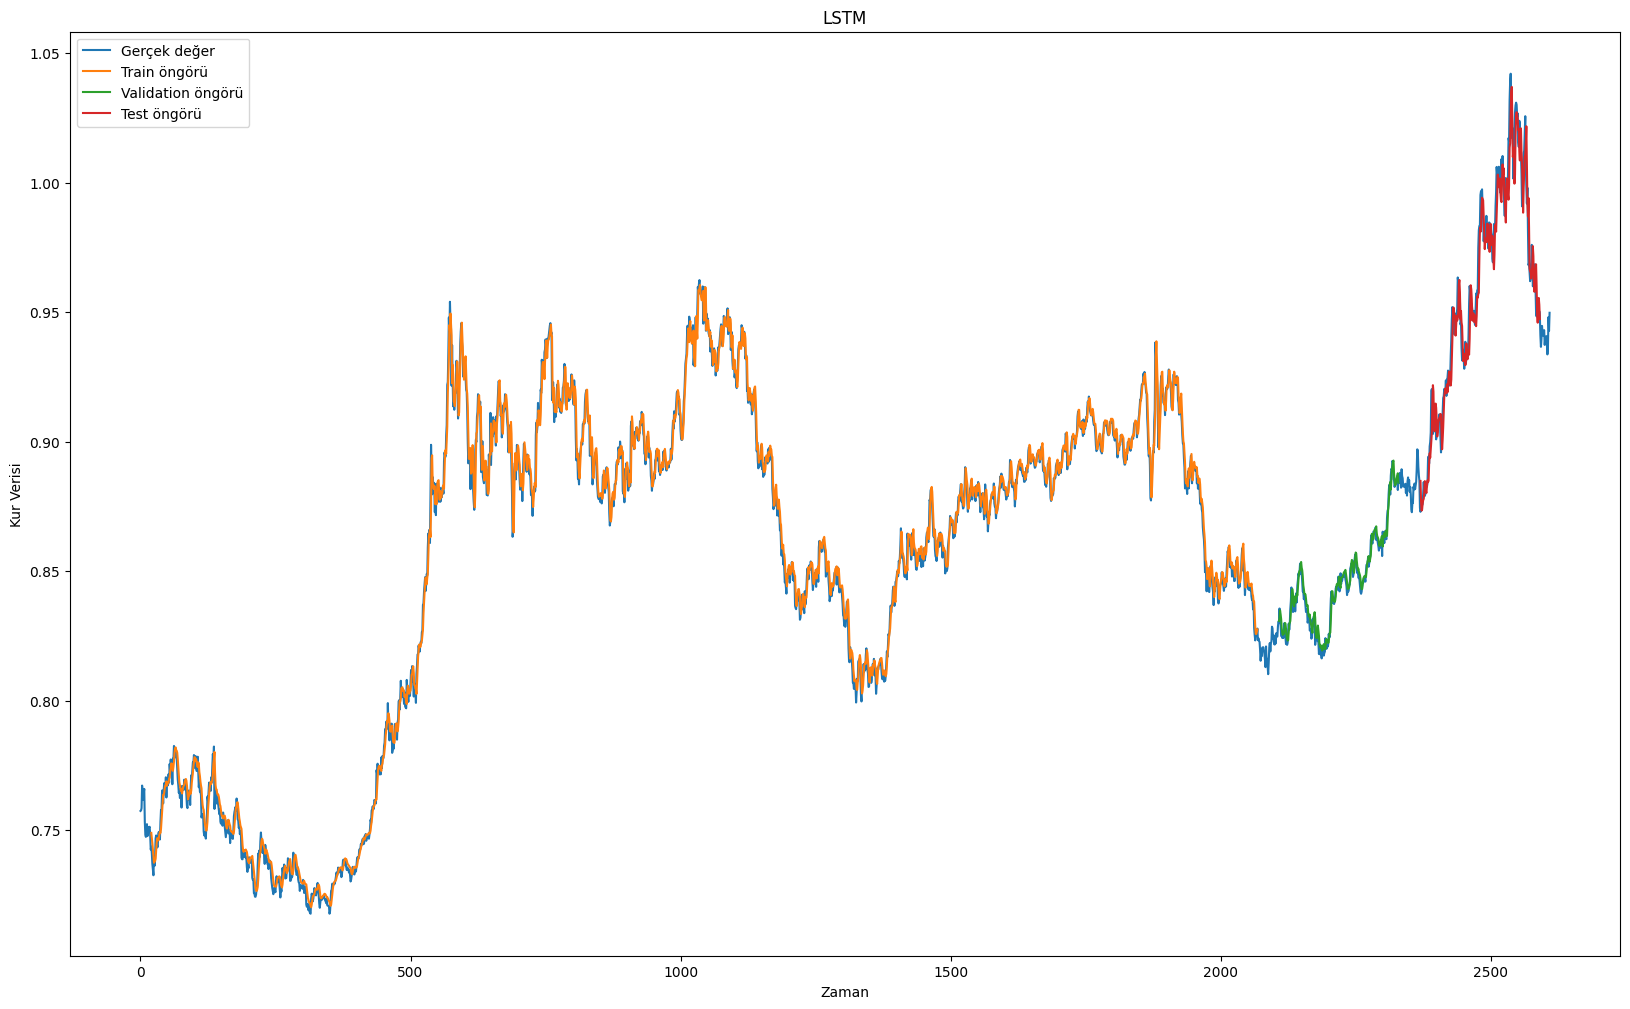

In [262]:
train_predict_plot = np.empty_like(df_reshaped)
train_predict_plot[:, :] = np.nan
train_predict_plot[n_lookback:len(train_predict) + n_lookback, :] = train_predict

valid_predict_plot = np.empty_like(df_reshaped)
valid_predict_plot[:, :] = np.nan
valid_predict_plot[len(train_predict) + (n_lookback * 2) + 19:len(df_reshaped) -len(test_predict)-n_lookback*2 - 18, :] = valid_predict

test_predict_plot = np.empty_like(df_reshaped)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + len(valid_predict) + (n_lookback * 2) + 59:len(df_reshaped) - 18, :] = test_predict

plt.figure(figsize = (20, 12))
plt.plot(df_reshaped, label = "Gerçek değer")
plt.plot(train_predict_plot, label = "Train öngörü")
plt.plot(valid_predict_plot, label = "Validation öngörü")
plt.plot(test_predict_plot, label = "Test öngörü")
plt.xlabel("Zaman")
plt.ylabel("Kur Verisi")
plt.legend()
plt.title("LSTM")
plt.show()

In [66]:
#GRU MODELİ
from keras import backend as K
K.clear_session()
model_gru = Sequential()
model_gru.add(GRU(7, input_shape=(n_lookback,1), activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_gru.add(Dense(n_future))
model_gru.compile(loss="mean_squared_error", optimizer="adam")
model_gru.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, batch_size=16, verbose=1, callbacks=[history])

Epoch 1/30
129/129 [==============================] - 18s 124ms/step - loss: 0.0281 - val_loss: 5.0905e-04
Epoch 2/30
129/129 [==============================] - 16s 125ms/step - loss: 0.0014 - val_loss: 2.0817e-04
Epoch 3/30
129/129 [==============================] - 16s 125ms/step - loss: 5.0024e-04 - val_loss: 1.9688e-04
Epoch 4/30
129/129 [==============================] - 16s 128ms/step - loss: 3.9244e-04 - val_loss: 1.6398e-04
Epoch 5/30
129/129 [==============================] - 10s 79ms/step - loss: 3.6887e-04 - val_loss: 1.6652e-04
Epoch 6/30
129/129 [==============================] - 8s 66ms/step - loss: 3.5949e-04 - val_loss: 1.7405e-04
Epoch 7/30
129/129 [==============================] - 9s 66ms/step - loss: 3.4909e-04 - val_loss: 1.5078e-04
Epoch 8/30
129/129 [==============================] - 9s 68ms/step - loss: 3.4375e-04 - val_loss: 1.5645e-04
Epoch 9/30
129/129 [==============================] - 9s 66ms/step - loss: 3.4200e-04 - val_loss: 1.4943e-04
Epoch 10/30
129/12

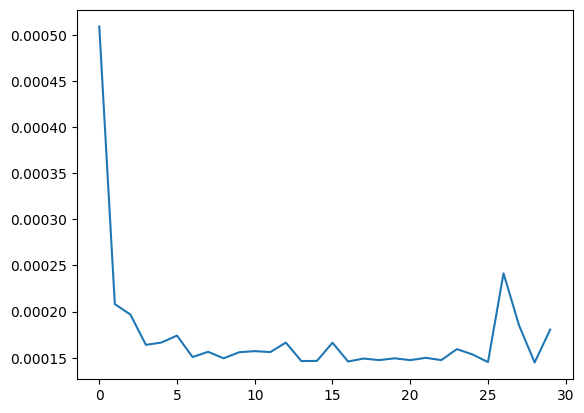

In [67]:
plt.plot(history.history["val_loss"])
plt.show()

In [238]:
rmse_train_gru, train_predict_gru = predict_ve_score(model_gru, X_train, y_train)
rmse_test_gru, test_predict_gru = predict_ve_score(model_gru, X_test, y_test)
rmse_valid_gru, valid_predict_gru = predict_ve_score(model_gru, X_valid, y_valid)
print("Training data score:  RMSE", rmse_train_gru)
print("Test data score: RMSE", rmse_test_gru)
print("Validation data score: RMSE", rmse_valid_gru)

7/7 [==============================] - 0s 10ms/step
Training data score:  RMSE 0.00462609520695452
Test data score: RMSE 0.00841723649830162
Validation data score: RMSE 0.0032335145414571407


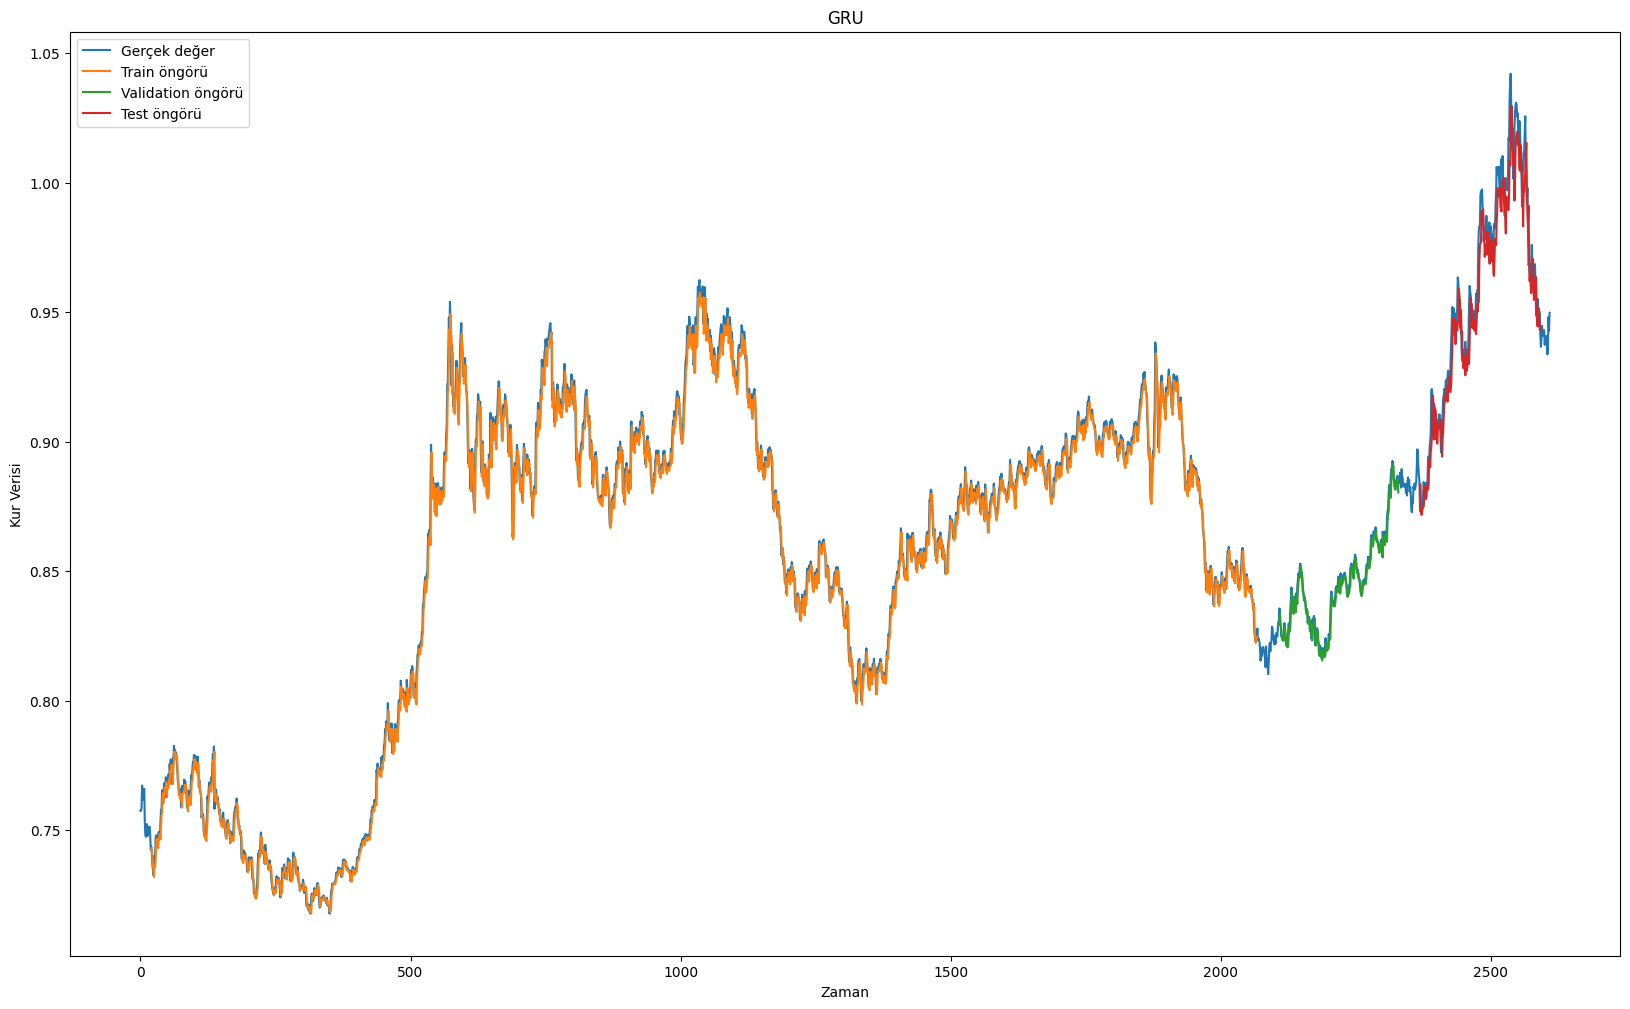

In [266]:
train_predict_plot = np.empty_like(df_reshaped)
train_predict_plot[:, :] = np.nan
train_predict_plot[n_lookback:len(train_predict) + n_lookback, :] = train_predict_gru

valid_predict_plot = np.empty_like(df_reshaped)
valid_predict_plot[:, :] = np.nan
valid_predict_plot[len(train_predict) + (n_lookback * 2) + 19:len(df_reshaped) -len(test_predict)-n_lookback*2 - 18, :] = valid_predict_gru

test_predict_plot = np.empty_like(df_reshaped)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + len(valid_predict) + (n_lookback * 2) + 59:len(df_reshaped) - 18, :] = test_predict_gru

plt.figure(figsize = (20, 12))
plt.plot(df_reshaped, label = "Gerçek değer")
plt.plot(train_predict_plot, label = "Train öngörü")
plt.plot(valid_predict_plot, label = "Validation öngörü")
plt.plot(test_predict_plot, label = "Test öngörü")
plt.xlabel("Zaman")
plt.ylabel("Kur Verisi")
plt.legend()
plt.title("GRU")
plt.show()

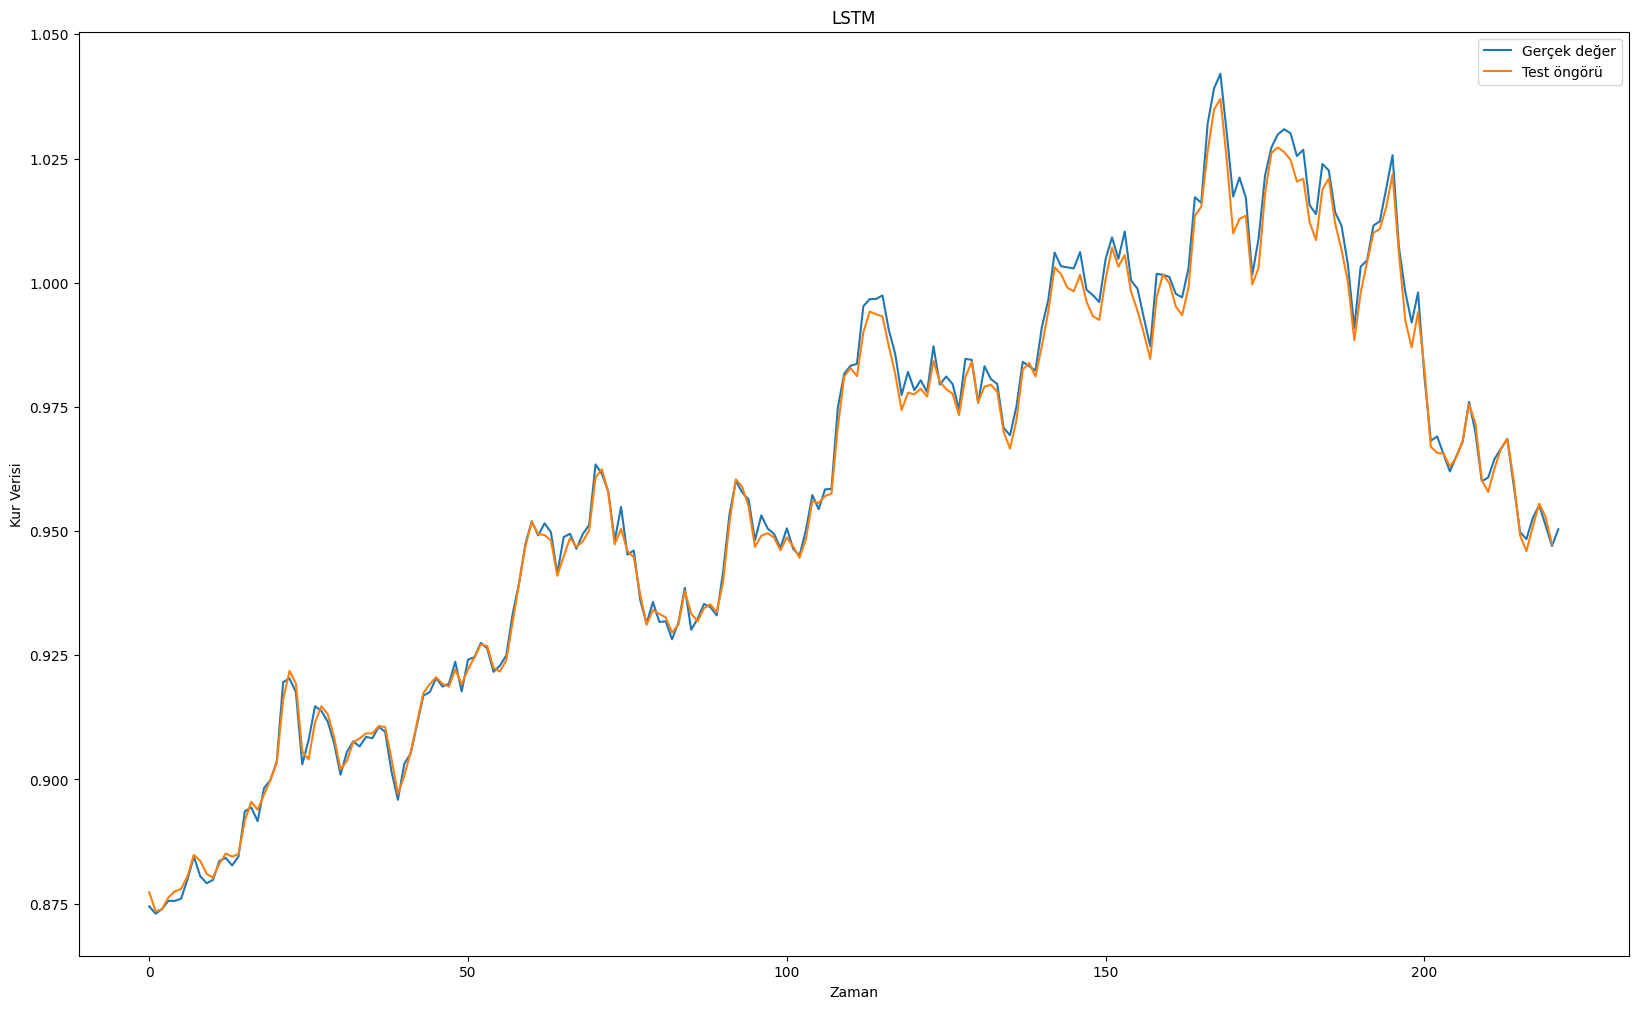

In [331]:
plt.figure(figsize = (20, 12))
plt.plot(y_test, label = "Gerçek değer")
plt.plot(test_predict[1: ], label = "Test öngörü")
plt.xlabel("Zaman")
plt.ylabel("Kur Verisi")
plt.legend()
plt.title("LSTM")
plt.show()

In [404]:
y_test = scaler.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))

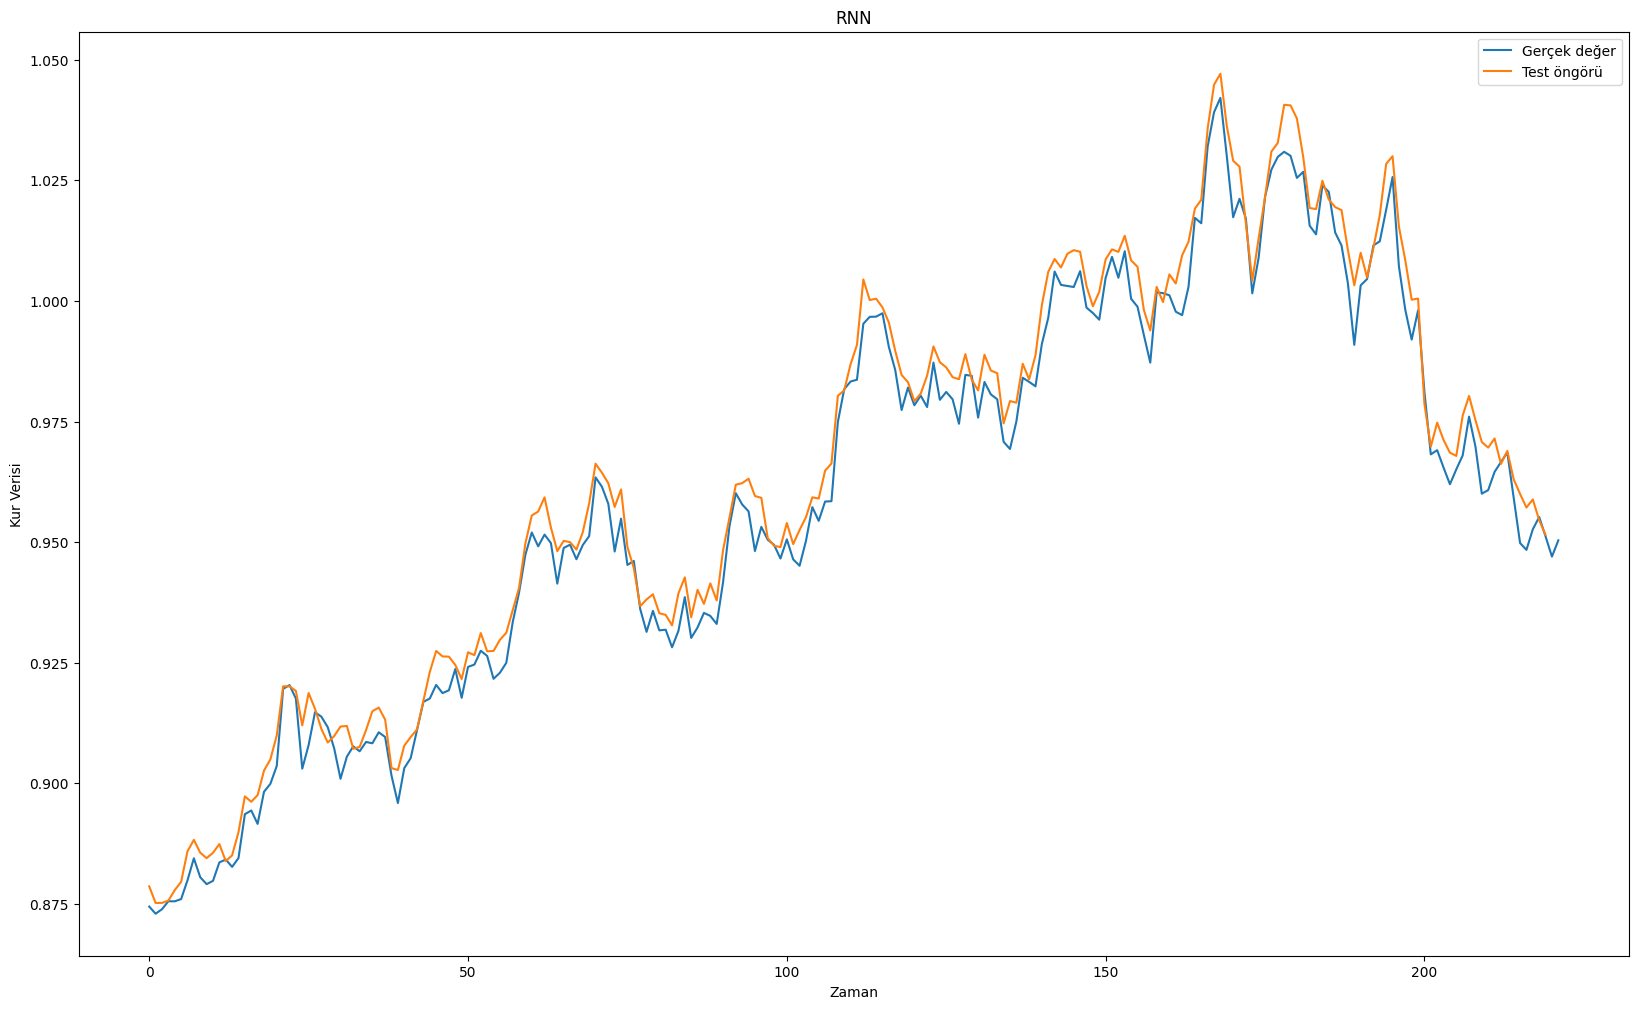

In [409]:
plt.figure(figsize = (20, 12))
plt.plot(y_test[: ], label = "Gerçek değer")
plt.plot(test_predict_rnn[2: ], label = "Test öngörü")
plt.xlabel("Zaman")
plt.ylabel("Kur Verisi")
plt.legend()
plt.title("RNN")
plt.show()